# L04: Wind Farm Feasibility Study

Notes:
- if wind below 3.5 or above 25, Power is 0
- use fxn to interpolate points to fit a function
- a wind turbine can't be 100% efficient because of the Betz Limit, theoretical max of .59 energy extraction. To generate power, a turbine must slow the wind, but stopping it completely would block further airflow, so some wind must pass through
- ignore section 3, answer all questions in section 2

- in question 2.1 ,dimension the wind farm: number of turbines (whole number)
- in question 2.7, asks for additional revenues (tax credits, renewable certificates, etc?). assume 20 yr timespan. value it at ZERO lol
- in question 2.3, dispatch rule -- dispatch if... use past data to look at prices
  - dispatch if market price is >= 0

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.interpolate import interp1d

In [19]:
# read data
df = pd.read_csv("./vermont_demand_price_2022.csv")
df2 = pd.read_csv("./Data_wind_temp.csv")

# Extract data
pprice = df["Price ($/MWh)"]
load = df["Load (MW)"]
temp = df2[" temperature (F)"]
wind_speed = df2["100m wind speed (m/s)"]

In [20]:
# interpolate power curve

v_cutin = 3.5 # m/s
v_cutout = 25 # m/s

wind_speeds = np.array([3.5, 4.5 , 5.5, 6, 7.5, 9, 10.5, 12, 14, 24.9]) # m/s
powers = np.array([0, 75, 200, 250, 500, 950, 1250, 1450, 1500, 1500]) # kW
interp = interp1d(wind_speeds,powers,kind="linear",fill_value="extrapolate")

def turbine_power(v):
    v_cutin = 3.5 # m/s
    v_cutout = 25 # m/s
    v_rated = 1500 #kw

    if v < v_cutin or v > v_cutout:
        return 0
    elif v_cutin <= v <= v_cutout:
        return float(interp(v))
    else:
        return 0

turbine_power_kw = [] # calculated using wind_speed from csv

for v in wind_speed:
    turbine_power_kw.append(turbine_power(v))


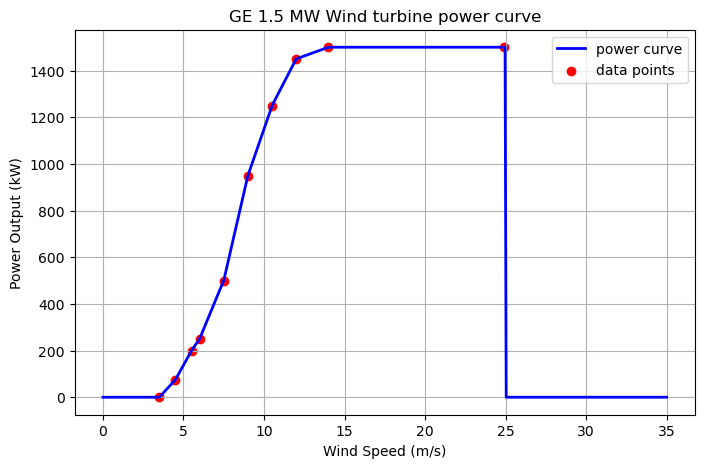

In [21]:
v = np.linspace(0, 35, 500)  # 0 to 35 m/s, 500 points

P = np.array([turbine_power(speed) for speed in v])

plt.figure(figsize=(8,5))
plt.plot(v, P, label="power curve", color='blue', linewidth=2)
plt.scatter(wind_speeds, powers, color='red', marker='o', label="data points")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power Output (kW)")
plt.title("GE 1.5 MW Wind turbine power curve")
plt.grid(True)
plt.legend()
plt.show()

For each power plant calculate the following:

1. Calculate the size (capacity) of the plant that is needed to ensure that it produces an average of 50 MW (electricity, ignore station service power) per year.
2. Compute the capacity factor for the power plant.
3. Using appropriate plant dispatch rules, Compute the number of hours in which the power plant will produce a non-zero amount of energy (i.e., plant is dispatched: ON and MW>0), given the prices of electricity and other factors, such as steam revenue and O&M costs (see below).
4. Calculate the 1-year revenue earned by selling electricity, heat and/or renewable energy credits at given/current market prices.
5. Estimate the annual operating and fuel costs for the plant, over a 20 year planning horizon. For each plant, assume that operations and maintenance (O&M) costs are currently
(a) for the natural gas O&M = $6/MWh generated/year plant, but you will also need to calculate the fuel cost (e.g., see the EIA site)
6. Calculate the annual cost of capital (i.e., the loan), assuming that capital is available for the project at a 5% interest rate, for a 20 year planning horizon. To do this calculation use the P TO A FORMULA assume that the bond (loan) for this project is spread over a 20 year period. In the equation above A is the annual cost of capital, P is the principle of the loan, r is the interest rate, and n is the number of periods (20).

7. Include in your analysis a table (or tables) that shows the revenues and costs over a 20 year period. To do this you will need to make some assumptions about how costs will change over time. State your assumptions. _We assume 

In [22]:
# hours on

hours_on = 0
for p in turbine_power_kw:
    if p > 0:
        hours_on += 1

print("hours on: ",hours_on)
print("yearly gen for 1 turbine MW:", sum(turbine_power_kw) / 1e3)

# capacity factor (actual energy out / possible energy out)

energy_out = sum(turbine_power_kw) / 1e3 # MW
possible_energy_out = 1.5 * 8760 # MW
cf = energy_out / possible_energy_out
print("capacity factor:  ", cf)

# size/cap required to produce 50MW/yr

ideal_cap_mw = 50
cap_mw = ideal_cap_mw / cf

# how many 1.5MW turbines?
num_turbines = cap_mw // 1.5
print("need this many 1.5MW turbines: ", num_turbines)

rev = 0
for h in range(8760):
    if turbine_power_kw[h] > 0:
        rev += turbine_power_kw[h] *  num_turbines / 1e3 * pprice[h]

print("rev: $", rev)

om_per_year = 43 / 1e-3 * 1.5 * num_turbines

print("om per year $: ", om_per_year)
print("profit yearly $: ", rev-om_per_year)


# compute annual cost of capital
#startup cost: $1.5 million per MW capacity
n = 20
r = .05
P = 1.5e6 * cap_mw

rn = (1+r) ** n

A = P * r * rn / (rn -1)
print("Annual cost of capital for loan: $", A)

# console output

hours on:  7863
yearly gen for 1 turbine MW: 6706.6221105
capacity factor:   0.510397420890411
need this many 1.5MW turbines:  65.0
rev: $ 37241178.17287423
om per year $:  4192500.0
profit yearly $:  33048678.172874227
Annual cost of capital for loan: $ 11791192.104385717


Model a 20-year outlook based on 3% inflation for power prices (electricity revenue) and escalation for 2.5% for O&M Costs based on ARBITRARY.

~~Annual O&M spending in 2017 $/kW-year = 39.083 + (1.119 × age) 
https://www.eia.gov/analysis/studies/powerplants/generationcost/pdf/full_report.pdf~~

In [23]:
# inflation rates
power_inflation = .03
om_inflation = .025

years = range(1, 21) # 20 year outlook
rows = []
for y in years:
    om_cost = om_per_year * (1 + om_inflation) ** (y-1)
    capital_payment = A  # same each year

    total_rev = rev * (1 + power_inflation) ** (y-1)
    total_cost = om_cost + capital_payment
    
    net = total_rev - total_cost

    rows.append({
        "Year": y,
        "O&M Cost ($) ": f"{om_cost:,.2f}",
        "Annuity Payment ($)": f"{capital_payment:,.2f}",
        "TotalCost ($)": f"{total_cost:,.2f}",
        "Total Rev ($)": f"{total_rev:,.2f}",
        "Net ($)": f"{net:,.2f}"
    })

df_20yrs = pd.DataFrame(rows)

print(df_20yrs)
df_20yrs.to_csv('20-year-table.csv', index=False)

    Year O&M Cost ($)  Annuity Payment ($)  TotalCost ($)  Total Rev ($)  \
0      1  4,192,500.00       11,791,192.10  15,983,692.10  37,241,178.17   
1      2  4,297,312.50       11,791,192.10  16,088,504.60  38,358,413.52   
2      3  4,404,745.31       11,791,192.10  16,195,937.42  39,509,165.92   
3      4  4,514,863.95       11,791,192.10  16,306,056.05  40,694,440.90   
4      5  4,627,735.54       11,791,192.10  16,418,927.65  41,915,274.13   
5      6  4,743,428.93       11,791,192.10  16,534,621.04  43,172,732.35   
6      7  4,862,014.66       11,791,192.10  16,653,206.76  44,467,914.32   
7      8  4,983,565.02       11,791,192.10  16,774,757.13  45,801,951.75   
8      9  5,108,154.15       11,791,192.10  16,899,346.25  47,176,010.31   
9     10  5,235,858.00       11,791,192.10  17,027,050.11  48,591,290.61   
10    11  5,366,754.45       11,791,192.10  17,157,946.56  50,049,029.33   
11    12  5,500,923.31       11,791,192.10  17,292,115.42  51,550,500.21   
12    13  5,